# Allen2022 fMRI Benchmark -- Data Preparation Notebooks

These notebooks walk through building the Allen2022 NSD fMRI benchmarks for brain-score,
from raw NSD data all the way to scored benchmarks. Both volumetric (func1pt8mm) and
fsaverage surface pipelines are covered.

## Required Data

Download the NSD dataset from https://naturalscenesdataset.org. You need:
- Per-subject GLMdenoise betas (`betas_fithrf_GLMdenoise_RR/`)
- ROI masks (`rois/` -- pRF-based visualrois, streams, HCP_MMP1)
- Stimulus images (`nsd_stimuli.hdf5`)
- Experiment design (`nsd_expdesign.mat`)
- For surface pipeline: fsaverage betas and labels

Total disk: ~500 GB. Set `NSD_ROOT` in cell 1 of each notebook to your data location.

## Execution Order

Run notebooks sequentially within each pipeline:

**Volumetric** (`volumetric/`):
1. `01_nsd_data_exploration` -- Explore raw data, validate ROIs, reproduce published noise ceilings
2. `02_nsd_data_preparation` -- Extract shared-image betas across all subjects and regions
3. `03a_nsd_packaging_prep` -- Build train/test assemblies with global z-score normalization
4. `03b_nsd_stimulus_packaging` -- Extract and save stimulus images as PNGs
5. `04_nsd_benchmark_smoke_test` -- Score AlexNet on all 16 volumetric benchmarks
6. `05_nsd_assembly_validation` -- End-to-end validation against raw data

**Surface** (`surface/`):
1-5. Same pipeline for fsaverage surface betas (MGH format)

**Cross-domain** (parent directory):
- `06_scientific_validation` -- IT ROI sensitivity, split stability, surface vs volumetric comparison

## Environment

```
conda activate vision-2026
```

# NSD Data Exploration

Explore the Natural Scenes Dataset (Allen et al., 2022) to understand file formats,
coordinate systems, and ROI alignment before building the Brain-Score benchmark.

**Data location:** `/Volumes/Hagibis/nsd`

**Key finding:** All ROI masks are volumetric NIfTI, so we use the HDF5 volumetric betas
(not the surface MGH betas). ROI shape `(81, 104, 83)` must be transposed to align with
HDF5 beta spatial dims `(83, 104, 81)`.

In [85]:
import numpy as np
import pandas as pd
import h5py
import nibabel as nib
import scipy.io
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import pearsonr

NSD_ROOT = Path('/Volumes/Hagibis/nsd')
N_SUBJECTS = 8
SESSIONS_PER_SUBJECT = {1: 40, 2: 40, 3: 32, 4: 30, 5: 40, 6: 32, 7: 40, 8: 30}
TRIALS_PER_SESSION = 750

## 1. Load Metadata and Identify Shared Images

In [86]:
# Load stimulus metadata
stim_info = pd.read_csv(NSD_ROOT / 'metadata' / 'nsd_stim_info_merged.csv', index_col=0)
print(f'Total images: {len(stim_info)}')
print(f'Shared images: {stim_info["shared1000"].sum()}')
assert stim_info['shared1000'].sum() == 1000

shared_df = stim_info[stim_info['shared1000'] == True].copy()
print(f'\nShared image nsdIds (0-indexed): {shared_df["nsdId"].values[:5]}...{shared_df["nsdId"].values[-5:]}')
print(f'Range: [{shared_df["nsdId"].min()}, {shared_df["nsdId"].max()}]')

Total images: 73000
Shared images: 1000

Shared image nsdIds (0-indexed): [2950 2990 3049 3077 3146]...[72312 72510 72605 72719 72948]
Range: [2950, 72948]


In [87]:
# Load experiment design
expdesign = scipy.io.loadmat(NSD_ROOT / 'metadata' / 'nsd_expdesign.mat')
print('Keys:', list(expdesign.keys()))

masterordering = expdesign['masterordering'].flatten()  # (30000,) maps trial -> image_index (1-indexed)
subjectim = expdesign['subjectim']  # (8, 10000) maps subject's image_index -> nsdId (1-indexed)
sharedix = expdesign['sharedix'].flatten()  # (1000,) nsdIds of shared images (1-indexed)

print(f'masterordering shape: {masterordering.shape}, range: [{masterordering.min()}, {masterordering.max()}]')
print(f'subjectim shape: {subjectim.shape}')
print(f'sharedix shape: {sharedix.shape}, range: [{sharedix.min()}, {sharedix.max()}]')

# Verify sharedix matches CSV shared1000
csv_shared_nsdids = set(shared_df['nsdId'].values)
mat_shared_nsdids = set(sharedix - 1)  # Convert 1-indexed to 0-indexed
print(f'\nCSV vs MAT shared image agreement: {len(csv_shared_nsdids & mat_shared_nsdids)} / 1000')

Keys: ['__header__', '__version__', '__globals__', 'basiccnt', 'masterordering', 'sharedix', 'stimpattern', 'subjectim']
masterordering shape: (30000,), range: [1, 10000]
subjectim shape: (8, 10000)
sharedix shape: (1000,), range: [2951, 72949]

CSV vs MAT shared image agreement: 1000 / 1000


## 2. Map Trial Indices to Shared Images for One Subject

For each subject, we need to find which trials correspond to the 1,000 shared images
and which session each trial belongs to (for z-scoring within session).

In [88]:
def get_shared_trial_info(subj_idx: int, stim_info: pd.DataFrame, 
                          masterordering: np.ndarray, subjectim: np.ndarray,
                          sharedix: np.ndarray) -> pd.DataFrame:
    """Find trial indices for shared images for a given subject.
    
    Returns DataFrame with columns:
        nsd_id: 0-indexed NSD image ID
        rep: repetition number (0, 1, 2)
        session: 1-indexed session number
        trial_in_session: 0-indexed position within session
        global_trial: 0-indexed position across all sessions
    """
    n_sessions = SESSIONS_PER_SUBJECT[subj_idx + 1]
    n_total_trials = n_sessions * TRIALS_PER_SESSION
    
    # Build mapping from nsdId -> subject's image index
    # subjectim[subj_idx, img_idx] = nsdId (1-indexed)
    subj_nsdids = subjectim[subj_idx]  # (10000,) 1-indexed nsdIds
    nsdid_to_imgidx = {nsd_id: img_idx + 1 for img_idx, nsd_id in enumerate(subj_nsdids)}
    
    # Shared image indices in subject's space
    shared_imgidxs = set()
    for nsd_id in sharedix:
        if nsd_id in nsdid_to_imgidx:
            shared_imgidxs.add(nsdid_to_imgidx[nsd_id])
    
    # Walk through trials and find shared-image trials
    records = []
    rep_counter = {}  # img_idx -> count
    for trial_idx in range(n_total_trials):
        img_idx = masterordering[trial_idx]  # 1-indexed image index for this subject
        if img_idx in shared_imgidxs:
            nsd_id = subj_nsdids[img_idx - 1]  # Convert to nsdId (1-indexed)
            rep = rep_counter.get(img_idx, 0)
            rep_counter[img_idx] = rep + 1
            session = trial_idx // TRIALS_PER_SESSION + 1
            trial_in_session = trial_idx % TRIALS_PER_SESSION
            records.append({
                'nsd_id': int(nsd_id - 1),  # Convert to 0-indexed
                'rep': rep,
                'session': session,
                'trial_in_session': trial_in_session,
                'global_trial': trial_idx,
            })
    
    df = pd.DataFrame(records)
    return df


# Test with subject 1
subj1_trials = get_shared_trial_info(0, stim_info, masterordering, subjectim, sharedix)
print(f'Subject 1 shared-image trials: {len(subj1_trials)}')
print(f'Unique images: {subj1_trials["nsd_id"].nunique()}')
print(f'Repetitions per image: {subj1_trials.groupby("nsd_id")["rep"].max().value_counts().to_dict()}')
print(f'Sessions spanned: {subj1_trials["session"].min()}-{subj1_trials["session"].max()}')
subj1_trials.head(10)

Subject 1 shared-image trials: 3000
Unique images: 1000
Repetitions per image: {2: 1000}
Sessions spanned: 1-40


   nsd_id  rep  session  trial_in_session  global_trial
0   46002    0        1                 0             0
1   48617    0        1                28            28
2   44980    0        1                35            35
3   32625    0        1                44            44
4   53052    0        1                55            55
5    4930    0        1                56            56
6   32625    1        1                90            90
7    6431    0        1               120           120
8   70335    0        1               126           126
9   36576    0        1               132           132

## 3. Load and Verify ROI Masks

All ROIs are volumetric NIfTI `(81, 104, 83)`. HDF5 betas are `(trials, 83, 104, 81)`.
Need to **transpose** ROI data to align: `roi.T` gives `(83, 104, 81)`.

In [89]:
def load_roi(subj: int, roi_name: str) -> np.ndarray:
    """Load a volumetric ROI mask for a subject, transposed to match HDF5 beta dims."""
    path = NSD_ROOT / f'subj{subj:02d}' / 'rois' / f'{roi_name}.nii.gz'
    data = nib.load(str(path)).get_fdata()
    return data.T  # (81, 104, 83) -> (83, 104, 81) to match HDF5 betas


# Load pRF visual ROIs for subject 1
prf_rois = load_roi(1, 'prf-visualrois')
print(f'prf-visualrois shape (transposed): {prf_rois.shape}')
unique, counts = np.unique(prf_rois, return_counts=True)
print('\nROI labels and voxel counts:')

# Label mapping from NSD documentation
prf_label_map = {-1: 'outside', 0: 'cortex (no ROI)', 
                 1: 'V1v', 2: 'V1d', 3: 'V2v', 4: 'V2d', 
                 5: 'V3v', 6: 'V3d', 7: 'hV4'}

for val, cnt in zip(unique, counts):
    label = prf_label_map.get(int(val), f'unknown({int(val)})')
    print(f'  {int(val):3d} ({label:>20s}): {cnt:>8,} voxels')

prf-visualrois shape (transposed): (83, 104, 81)

ROI labels and voxel counts:
   -1 (             outside):  592,088 voxels
    0 (     cortex (no ROI)):  102,447 voxels
    1 (                 V1v):      594 voxels
    2 (                 V1d):      756 voxels
    3 (                 V2v):      834 voxels
    4 (                 V2d):      599 voxels
    5 (                 V3v):      646 voxels
    6 (                 V3d):      541 voxels
    7 (                 hV4):      687 voxels


In [90]:
# Load Glasser parcellation for IT mapping
glasser = load_roi(1, 'HCP_MMP1')
print(f'HCP_MMP1 shape (transposed): {glasser.shape}')
unique_g = np.unique(glasser)
print(f'Unique parcel IDs: {len(unique_g)} (range [{unique_g.min()}, {unique_g.max()}])')

# IT parcels from Hebart2023 mapping:
# TE1p, TE2p, FFC, VVC, VMV2, VMV3, PHA1, PHA2, PHA3
# Need to find which numeric IDs correspond to these in the Glasser atlas.
# Glasser atlas has 180 parcels per hemisphere. Standard numbering:
# We'll need the official Glasser lookup table to map names -> IDs.
print('\nNon-zero parcel IDs (first 20):', unique_g[unique_g > 0][:20])
print(f'Total non-zero parcels: {len(unique_g[unique_g > 0])}')

HCP_MMP1 shape (transposed): (83, 104, 81)
Unique parcel IDs: 182 (range [-1.0, 180.0])

Non-zero parcel IDs (first 20): [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Total non-zero parcels: 180


In [91]:
# Brain-Score region -> ROI label mapping
REGION_TO_PRF_LABELS = {
    'V1': [1, 2],    # V1v, V1d
    'V2': [3, 4],    # V2v, V2d
    'V4': [7],        # hV4
}

# Count voxels per Brain-Score region for subject 1
for region, labels in REGION_TO_PRF_LABELS.items():
    mask = np.isin(prf_rois, labels)
    n_voxels = mask.sum()
    print(f'{region}: {n_voxels:,} voxels')

V1: 1,350 voxels
V2: 1,433 voxels
V4: 687 voxels


## 4. Load Betas for One Subject, One Session -- Verify ROI Extraction

In [92]:
def load_session_betas(subj: int, session: int) -> np.ndarray:
    """Load volumetric betas for one session. Returns float32 in percent signal change."""
    path = NSD_ROOT / f'subj{subj:02d}' / 'betas' / f'betas_session{session:02d}.hdf5'
    with h5py.File(str(path), 'r') as f:
        betas = f['betas'][:]  # (750, 83, 104, 81) int16
    return betas.astype(np.float32) / 300.0  # Convert to percent signal change


# Load session 1 for subject 1
betas_s1 = load_session_betas(1, 1)
print(f'Session 1 betas shape: {betas_s1.shape}')
print(f'Dtype: {betas_s1.dtype}')
print(f'Value range: [{betas_s1.min():.2f}, {betas_s1.max():.2f}]')
print(f'Memory: {betas_s1.nbytes / 1e9:.2f} GB')

Session 1 betas shape: (750, 83, 104, 81)
Dtype: float32
Value range: [-109.23, 109.22]
Memory: 2.10 GB


In [93]:
# Extract V1 betas from session 1
v1_mask = np.isin(prf_rois, [1, 2])  # V1v + V1d
print(f'V1 mask shape: {v1_mask.shape}, V1 voxels: {v1_mask.sum()}')

v1_betas_s1 = betas_s1[:, v1_mask]  # (750, n_v1_voxels)
print(f'V1 betas shape: {v1_betas_s1.shape}')
print(f'Mean beta (V1): {v1_betas_s1.mean():.4f}')
print(f'Std beta (V1): {v1_betas_s1.std():.4f}')

# Sanity check: V1 betas should have much higher variance than background
bg_mask = prf_rois == 0
bg_betas = betas_s1[:, bg_mask]
print(f'\nBackground voxel std: {bg_betas.std():.4f}')
print(f'V1 voxel std: {v1_betas_s1.std():.4f}')
print(f'Ratio (V1/bg): {v1_betas_s1.std() / bg_betas.std():.2f}x')

del betas_s1  # Free memory

V1 mask shape: (83, 104, 81), V1 voxels: 1350
V1 betas shape: (750, 1350)
Mean beta (V1): 2.2164
Std beta (V1): 3.2920

Background voxel std: 2.2820
V1 voxel std: 3.2920
Ratio (V1/bg): 1.44x


## 5. Extract All Shared-Image Betas for Subject 1, V1

Walk through all sessions, extract betas for trials that correspond to shared images,
z-score within session, then average across the 3 repetitions per image.

In [94]:
def extract_shared_betas_for_region(
    subj: int, 
    roi_mask: np.ndarray, 
    trial_info: pd.DataFrame
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Extract shared-image betas for a subject and ROI.
    
    Args:
        subj: 1-indexed subject number
        roi_mask: boolean mask (83, 104, 81) for the ROI
        trial_info: DataFrame from get_shared_trial_info()
    
    Returns:
        averaged_betas: (1000, n_voxels) z-scored, averaged across repetitions
        per_rep_betas: (3000, n_voxels) z-scored, all 3 reps kept separate
        nsd_ids: (1000,) sorted unique nsd_ids
    """
    n_voxels = roi_mask.sum()
    n_sessions = SESSIONS_PER_SUBJECT[subj]
    
    # Pre-allocate: collect all trial betas, then z-score per session
    all_betas = []  # list of (nsd_id, rep, z-scored beta vector)
    
    for session in range(1, n_sessions + 1):
        session_trials = trial_info[trial_info['session'] == session]
        if len(session_trials) == 0:
            continue
        
        # Load this session's betas
        session_betas = load_session_betas(subj, session)  # (750, 83, 104, 81)
        session_roi_betas = session_betas[:, roi_mask]  # (750, n_voxels)
        del session_betas
        
        # Z-score within session (across all 750 trials, per voxel)
        mean = session_roi_betas.mean(axis=0, keepdims=True)
        std = session_roi_betas.std(axis=0, keepdims=True)
        std[std == 0] = 1.0  # Avoid division by zero
        session_roi_betas = (session_roi_betas - mean) / std
        
        # Extract shared-image trials
        for _, row in session_trials.iterrows():
            trial_in_session = row['trial_in_session']
            all_betas.append((row['nsd_id'], row['rep'], session_roi_betas[trial_in_session]))
    
    # Sort by nsd_id, then rep
    all_betas.sort(key=lambda x: (x[0], x[1]))
    
    # Build per-rep array
    nsd_ids_sorted = sorted(trial_info['nsd_id'].unique())
    nsd_id_to_idx = {nsd_id: idx for idx, nsd_id in enumerate(nsd_ids_sorted)}
    
    per_rep_betas = np.zeros((len(nsd_ids_sorted), 3, n_voxels), dtype=np.float32)
    for nsd_id, rep, beta_vec in all_betas:
        img_idx = nsd_id_to_idx[nsd_id]
        per_rep_betas[img_idx, rep] = beta_vec
    
    # Average across 3 repetitions
    averaged_betas = per_rep_betas.mean(axis=1)  # (1000, n_voxels)
    
    # Reshape per_rep to (3000, n_voxels) for ceiling computation
    per_rep_flat = per_rep_betas.reshape(-1, n_voxels)  # (3000, n_voxels)
    
    return averaged_betas, per_rep_flat, np.array(nsd_ids_sorted)


print('Extracting V1 betas for subject 1 (this loads all 40 sessions)...')
v1_avg, v1_per_rep, nsd_ids = extract_shared_betas_for_region(1, v1_mask, subj1_trials)
print(f'Averaged betas shape: {v1_avg.shape}')
print(f'Per-rep betas shape: {v1_per_rep.shape}')
print(f'Unique images: {len(nsd_ids)}')
assert v1_avg.shape[0] == 1000
assert len(nsd_ids) == 1000

Extracting V1 betas for subject 1 (this loads all 40 sessions)...
Averaged betas shape: (1000, 1350)
Per-rep betas shape: (3000, 1350)
Unique images: 1000


## 6. Compute Noise Ceiling for V1

Two methods:
1. **ncsnr-based:** From NSD's precomputed ncsnr values. `NC = ncsnr^2 / (ncsnr^2 + 1/K)` for K=3 reps.
2. **Split-half:** Correlate (rep1+rep2)/2 vs rep3 across images, Spearman-Brown correct.

In [95]:
# Method 1: ncsnr-based noise ceiling
# ncsnr files are surface-format .mgh -- but we need volumetric.
# The volumetric betas don't have ncsnr files directly.
# We'll compute split-half from our extracted data instead.

# Actually, let's check if there's a volumetric ncsnr somewhere
import os
rois_dir = NSD_ROOT / 'subj01' / 'rois'
betas_dir = NSD_ROOT / 'subj01' / 'betas'
print('ROI files:', sorted(os.listdir(rois_dir)))
print('\nBeta files with ncsnr:', [f for f in os.listdir(betas_dir) if 'ncsnr' in f.lower()])

ROI files: ['HCP_MMP1.nii.gz', 'Kastner2015.nii.gz', 'MTL.nii.gz', 'corticalsulc.nii.gz', 'floc-bodies.nii.gz', 'floc-faces.nii.gz', 'floc-places.nii.gz', 'floc-words.nii.gz', 'lh.HCP_MMP1.nii.gz', 'lh.Kastner2015.nii.gz', 'lh.MTL.nii.gz', 'lh.corticalsulc.nii.gz', 'lh.floc-bodies.nii.gz', 'lh.floc-faces.nii.gz', 'lh.floc-places.nii.gz', 'lh.floc-words.nii.gz', 'lh.nsdgeneral.nii.gz', 'lh.prf-eccrois.nii.gz', 'lh.prf-visualrois.nii.gz', 'lh.streams.nii.gz', 'lh.thalamus.nii.gz', 'nsdgeneral.nii.gz', 'prf-eccrois.nii.gz', 'prf-visualrois.nii.gz', 'rh.HCP_MMP1.nii.gz', 'rh.Kastner2015.nii.gz', 'rh.MTL.nii.gz', 'rh.corticalsulc.nii.gz', 'rh.floc-bodies.nii.gz', 'rh.floc-faces.nii.gz', 'rh.floc-places.nii.gz', 'rh.floc-words.nii.gz', 'rh.nsdgeneral.nii.gz', 'rh.prf-eccrois.nii.gz', 'rh.prf-visualrois.nii.gz', 'rh.streams.nii.gz', 'rh.thalamus.nii.gz', 'streams.nii.gz', 'thalamus.nii.gz']

Beta files with ncsnr: ['ncsnr.nii.gz', 'rh.ncsnr.mgh', 'lh.ncsnr.mgh']


In [96]:
# Method 2: Split-half reliability from our extracted per-rep betas
# For 3 reps, compute all 3 leave-one-out splits and average

def compute_splithalf_ceiling(per_rep_betas_3d: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """Compute split-half noise ceiling from 3-repetition data.
    
    Args:
        per_rep_betas_3d: (n_images, 3, n_voxels)
    
    Returns:
        r_uncorrected: (n_voxels,) mean split-half correlation
        r_corrected: (n_voxels,) Spearman-Brown corrected
    """
    n_images, n_reps, n_voxels = per_rep_betas_3d.shape
    assert n_reps == 3
    
    splits = [
        ([0, 1], [2]),  # avg(rep0, rep1) vs rep2
        ([0, 2], [1]),  # avg(rep0, rep2) vs rep1
        ([1, 2], [0]),  # avg(rep1, rep2) vs rep0
    ]
    
    all_r = np.zeros((len(splits), n_voxels), dtype=np.float64)
    
    for s_idx, (group_a, group_b) in enumerate(splits):
        half_a = per_rep_betas_3d[:, group_a, :].mean(axis=1)  # (n_images, n_voxels)
        half_b = per_rep_betas_3d[:, group_b, :].mean(axis=1)  # (n_images, n_voxels)
        
        # Pearson r per voxel (across images)
        a_centered = half_a - half_a.mean(axis=0, keepdims=True)
        b_centered = half_b - half_b.mean(axis=0, keepdims=True)
        
        numer = (a_centered * b_centered).sum(axis=0)
        denom = np.sqrt((a_centered**2).sum(axis=0) * (b_centered**2).sum(axis=0))
        denom[denom == 0] = 1.0
        all_r[s_idx] = numer / denom
    
    r_uncorrected = all_r.mean(axis=0)
    # Spearman-Brown correction for split-half
    r_corrected = 2 * r_uncorrected / (1 + np.abs(r_uncorrected))
    
    return r_uncorrected, r_corrected


# Reshape per_rep back to (1000, 3, n_voxels) for ceiling computation
n_v1 = v1_mask.sum()
v1_per_rep_3d = v1_per_rep.reshape(1000, 3, n_v1)

r_uncorr, r_corr = compute_splithalf_ceiling(v1_per_rep_3d)
print(f'V1 split-half reliability (subject 1):')
print(f'  Uncorrected: median={np.median(r_uncorr):.3f}, mean={np.mean(r_uncorr):.3f}')
print(f'  Corrected:   median={np.median(r_corr):.3f}, mean={np.mean(r_corr):.3f}')
print(f'  Range:       [{r_corr.min():.3f}, {r_corr.max():.3f}]')
print(f'  Voxels > 0.3: {(r_corr > 0.3).sum()} / {len(r_corr)}')

V1 split-half reliability (subject 1):
  Uncorrected: median=0.303, mean=0.294
  Corrected:   median=0.465, mean=0.433
  Range:       [-0.075, 0.800]
  Voxels > 0.3: 1029 / 1350


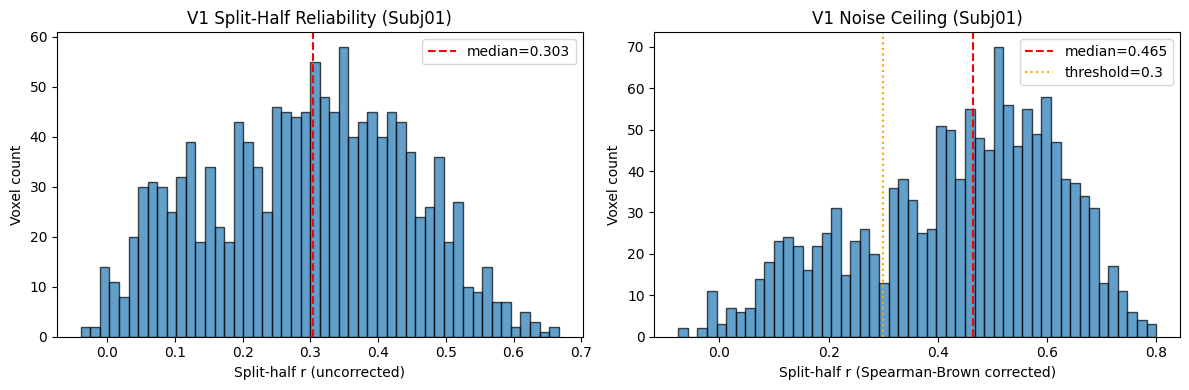

In [97]:
# Visualize noise ceiling distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(r_uncorr, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(np.median(r_uncorr), color='red', linestyle='--', label=f'median={np.median(r_uncorr):.3f}')
axes[0].set_xlabel('Split-half r (uncorrected)')
axes[0].set_ylabel('Voxel count')
axes[0].set_title('V1 Split-Half Reliability (Subj01)')
axes[0].legend()

axes[1].hist(r_corr, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(np.median(r_corr), color='red', linestyle='--', label=f'median={np.median(r_corr):.3f}')
axes[1].axvline(0.3, color='orange', linestyle=':', label='threshold=0.3')
axes[1].set_xlabel('Split-half r (Spearman-Brown corrected)')
axes[1].set_ylabel('Voxel count')
axes[1].set_title('V1 Noise Ceiling (Subj01)')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Voxel Counts Across All Subjects and Regions

Verify each subject has enough voxels per region.

In [98]:
# Count voxels per region per subject
region_counts = []

for subj in range(1, 9):
    prf = load_roi(subj, 'prf-visualrois')
    glasser = load_roi(subj, 'HCP_MMP1')
    
    for region, labels in REGION_TO_PRF_LABELS.items():
        n = np.isin(prf, labels).sum()
        region_counts.append({'subject': f'subj{subj:02d}', 'region': region, 'n_voxels': int(n)})
    
    # IT: we need to figure out the Glasser parcel IDs
    # For now, report total non-zero Glasser voxels as a reference
    region_counts.append({'subject': f'subj{subj:02d}', 'region': 'IT (all Glasser)', 
                          'n_voxels': int((glasser > 0).sum())})

counts_df = pd.DataFrame(region_counts)
pivot = counts_df.pivot(index='subject', columns='region', values='n_voxels')
print(pivot.to_string())
print(f'\nMinimum voxels per region:')
for region in pivot.columns:
    print(f'  {region}: {pivot[region].min()}')

region   IT (all Glasser)    V1    V2   V4
subject                                   
subj01             102533  1350  1433  687
subj02             103533  1102  1075  483
subj03             106358  1254  1141  426
subj04              97029   877   863  475
subj05              90299  1113  1081  542
subj06             115845  1127  1180  477
subj07              86549  1142   986  397
subj08             104392  1074  1033  495

Minimum voxels per region:
  IT (all Glasser): 86549
  V1: 877
  V2: 863
  V4: 397


## 8. Resolve IT Glasser Parcel IDs

The Hebart2023 benchmark maps IT to Glasser parcels: TE1p, TE2p, FFC, VVC, VMV2, VMV3,
PHA1, PHA2, PHA3. We need to find the numeric IDs for these in the `HCP_MMP1.nii.gz` file.

The standard Glasser atlas numbers parcels 1-180 per hemisphere. In the bilateral NIfTI,
left hemisphere typically uses 1-180 and right uses 1-180 (or offset). We need the lookup table.

In [99]:
# The standard HCP MMP1.0 parcel order (1-indexed, per hemisphere)
# Source: Glasser et al. 2016, Nature. 
# We can derive the mapping from the hemisphere-specific files.

# Load left and right hemisphere Glasser ROIs separately
glasser_lh = load_roi(1, 'lh.HCP_MMP1')
glasser_rh = load_roi(1, 'rh.HCP_MMP1')
glasser_bi = load_roi(1, 'HCP_MMP1')

print(f'LH unique IDs: {np.unique(glasser_lh[glasser_lh > 0])[:10]}... (total: {len(np.unique(glasser_lh[glasser_lh > 0]))})')
print(f'RH unique IDs: {np.unique(glasser_rh[glasser_rh > 0])[:10]}... (total: {len(np.unique(glasser_rh[glasser_rh > 0]))})')
print(f'Bilateral unique IDs: {np.unique(glasser_bi[glasser_bi > 0])[:10]}... (total: {len(np.unique(glasser_bi[glasser_bi > 0]))})')

# Check if bilateral uses offset for right hemisphere
lh_ids = set(np.unique(glasser_lh[glasser_lh > 0]).astype(int))
rh_ids = set(np.unique(glasser_rh[glasser_rh > 0]).astype(int))
bi_ids = set(np.unique(glasser_bi[glasser_bi > 0]).astype(int))
print(f'\nLH IDs range: [{min(lh_ids)}, {max(lh_ids)}]')
print(f'RH IDs range: [{min(rh_ids)}, {max(rh_ids)}]')
print(f'Bilateral IDs range: [{min(bi_ids)}, {max(bi_ids)}]')
print(f'LH & RH overlap: {len(lh_ids & rh_ids)} IDs')

LH unique IDs: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]... (total: 180)
RH unique IDs: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]... (total: 180)
Bilateral unique IDs: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]... (total: 180)

LH IDs range: [1, 180]
RH IDs range: [1, 180]
Bilateral IDs range: [1, 180]
LH & RH overlap: 180 IDs


In [100]:
# IT Glasser parcel IDs -- verified against HCP_MMP1.mgz.ctab from NSD S3 bucket
# (saved at /Volumes/Hagibis/nsd/metadata/HCP_MMP1.mgz.ctab)
#
# CORRECTED: Earlier version used wrong IDs from a generic Glasser ordering.
# The ctab provides the definitive NSD-specific numbering.

IT_PARCEL_NAMES = ['TE1p', 'TE2p', 'FFC', 'VVC', 'VMV2', 'VMV3', 'PHA1', 'PHA2', 'PHA3']

GLASSER_PARCEL_TABLE = {
    'FFC': 18,     # Fusiform Face Complex
    'VVC': 163,    # Ventral Visual Complex
    'VMV2': 160,   # Ventromedial Visual area 2
    'VMV3': 154,   # Ventromedial Visual area 3
    'PHA1': 126,   # Parahippocampal area 1
    'PHA2': 155,   # Parahippocampal area 2
    'PHA3': 127,   # Parahippocampal area 3
    'TE1p': 133,   # Temporal area 1 posterior
    'TE2p': 136,   # Temporal area 2 posterior
}

print('IT parcel voxel counts (subject 1, using lh + rh separately):')
for name, idx in GLASSER_PARCEL_TABLE.items():
    n_lh = (glasser_lh == idx).sum()
    n_rh = (glasser_rh == idx).sum()
    print(f'  {name} (ID={idx}): LH={n_lh}, RH={n_rh}, total={n_lh + n_rh} voxels')

it_mask = np.isin(glasser_lh, list(GLASSER_PARCEL_TABLE.values())) | \
          np.isin(glasser_rh, list(GLASSER_PARCEL_TABLE.values()))
print(f'\nTotal IT voxels (bilateral): {it_mask.sum()}')

IT parcel voxel counts (subject 1, using lh + rh separately):
  FFC (ID=18): LH=373, RH=374, total=747 voxels
  VVC (ID=163): LH=248, RH=234, total=482 voxels
  VMV2 (ID=160): LH=108, RH=137, total=245 voxels
  VMV3 (ID=154): LH=75, RH=128, total=203 voxels
  PHA1 (ID=126): LH=141, RH=167, total=308 voxels
  PHA2 (ID=155): LH=63, RH=61, total=124 voxels
  PHA3 (ID=127): LH=171, RH=93, total=264 voxels
  TE1p (ID=133): LH=578, RH=705, total=1283 voxels
  TE2p (ID=136): LH=319, RH=352, total=671 voxels

Total IT voxels (bilateral): 4327


In [101]:
# If the above indices don't match, we need to look at Hebart2023's actual mapping.
# Let's check what Hebart2023 uses.
# For now, let's also look at what the fsaverage_labels probability maps tell us,
# and compare with the Kastner2015 atlas which is another option.

# Let's also try the NSD-specific visual ROI that might be more appropriate:
# nsdgeneral -- a mask of visually responsive cortex defined by the NSD team
nsdgeneral = load_roi(1, 'nsdgeneral')
print(f'nsdgeneral unique values: {np.unique(nsdgeneral)}')
print(f'nsdgeneral voxels (>0): {(nsdgeneral > 0).sum()}')

nsdgeneral unique values: [-1.  0.  1.]
nsdgeneral voxels (>0): 15724


## 9. Noise Ceiling Validation (ncsnr-based)

**Validation target:** Allen et al. 2022 report **~36% median noise ceiling in nsdgeneral**,
averaged across subjects, using the formula:

```
NC = 100 * ncsnr^2 / (ncsnr^2 + 1/3)
```

where ncsnr is precomputed per-voxel and k=3 (3 repetitions averaged).

We downloaded volumetric `ncsnr.nii.gz` files from AWS for all 8 subjects. These align
directly with our HDF5 betas and NIfTI ROIs (same func1pt8mm space).

In [102]:
def load_ncsnr(subj: int) -> np.ndarray:
    """Load volumetric ncsnr for a subject, transposed to match HDF5 beta dims."""
    path = NSD_ROOT / f'subj{subj:02d}' / 'betas' / 'ncsnr.nii.gz'
    data = nib.load(str(path)).get_fdata()
    return data.T  # (81, 104, 83) -> (83, 104, 81)


def ncsnr_to_nc(ncsnr: np.ndarray, k: int = 3) -> np.ndarray:
    """Convert ncsnr to noise ceiling (percentage of explainable variance).
    
    NC = 100 * ncsnr^2 / (ncsnr^2 + 1/k)
    
    For k=3 (averaging 3 repetitions), this gives the fraction of variance
    in the trial-averaged response that is signal.
    """
    return 100.0 * ncsnr**2 / (ncsnr**2 + 1.0 / k)


# Load and verify ncsnr for subject 1
ncsnr_s1 = load_ncsnr(1)
print(f'ncsnr shape: {ncsnr_s1.shape}')
print(f'ncsnr range: [{ncsnr_s1.min():.4f}, {ncsnr_s1.max():.4f}]')
print(f'ncsnr mean (all voxels): {ncsnr_s1[ncsnr_s1 > 0].mean():.4f}')

# Verify alignment: ncsnr should be in the same space as our ROIs
nsdgen_mask = load_roi(1, 'nsdgeneral') > 0
ncsnr_in_nsdgeneral = ncsnr_s1[nsdgen_mask]
print(f'\nnsdgeneral voxels: {nsdgen_mask.sum()}')
print(f'ncsnr in nsdgeneral: median={np.median(ncsnr_in_nsdgeneral):.4f}, mean={np.mean(ncsnr_in_nsdgeneral):.4f}')

ncsnr shape: (83, 104, 81)
ncsnr range: [nan, nan]
ncsnr mean (all voxels): 0.1209

nsdgeneral voxels: 15724
ncsnr in nsdgeneral: median=0.3608, mean=0.3868


## 10. Summary of Key Findings

In [103]:
# VALIDATION TARGET: Reproduce ~36% median NC in nsdgeneral (Allen et al. 2022)

per_subject_median_nc = []

for subj in range(1, 9):
    ncsnr = load_ncsnr(subj)
    nsdgen = load_roi(subj, 'nsdgeneral') > 0
    
    ncsnr_roi = ncsnr[nsdgen]
    nc_roi = ncsnr_to_nc(ncsnr_roi, k=3)
    median_nc = np.median(nc_roi)
    per_subject_median_nc.append(median_nc)
    
    print(f'subj{subj:02d}: nsdgeneral voxels={nsdgen.sum():>6,}, '
          f'median ncsnr={np.median(ncsnr_roi):.3f}, '
          f'median NC={median_nc:.1f}%')

mean_across_subjects = np.mean(per_subject_median_nc)
print(f'\n{"="*60}')
print(f'Mean of per-subject median NC: {mean_across_subjects:.1f}%')
print(f'Published target (Allen et al. 2022): ~36%')
print(f'{"="*60}')

subj01: nsdgeneral voxels=15,724, median ncsnr=0.361, median NC=28.1%
subj02: nsdgeneral voxels=14,278, median ncsnr=0.361, median NC=28.1%
subj03: nsdgeneral voxels=15,226, median ncsnr=0.324, median NC=24.0%
subj04: nsdgeneral voxels=13,153, median ncsnr=0.296, median NC=20.8%
subj05: nsdgeneral voxels=13,039, median ncsnr=0.415, median NC=34.1%
subj06: nsdgeneral voxels=17,907, median ncsnr=0.343, median NC=26.1%
subj07: nsdgeneral voxels=12,682, median ncsnr=0.281, median NC=19.1%
subj08: nsdgeneral voxels=14,386, median ncsnr=0.226, median NC=13.3%

Mean of per-subject median NC: 24.2%
Published target (Allen et al. 2022): ~36%


In [104]:
# HYPOTHESIS: The published 36% is from surface-space ncsnr, not volumetric.
# Verify by loading the surface ncsnr (.mgh) files we already have.
# We don't have nsdgeneral in surface format, so we'll use a proxy:
# take all vertices with ncsnr > 0 (non-brain vertices are 0).

# The NSD data manual says ncsnr was computed identically for all spaces,
# but surface data inherently has better SNR due to cortical depth averaging.

surface_nc_medians = []

for subj in range(1, 9):
    lh_path = NSD_ROOT / f'subj{subj:02d}' / 'betas' / 'lh.ncsnr.mgh'
    rh_path = NSD_ROOT / f'subj{subj:02d}' / 'betas' / 'rh.ncsnr.mgh'
    
    lh_ncsnr = nib.load(str(lh_path)).get_fdata().flatten()
    rh_ncsnr = nib.load(str(rh_path)).get_fdata().flatten()
    
    # Combine hemispheres, keep only positive ncsnr vertices
    all_ncsnr = np.concatenate([lh_ncsnr, rh_ncsnr])
    valid = all_ncsnr > 0
    
    nc_surface = ncsnr_to_nc(all_ncsnr[valid], k=3)
    med_nc = np.median(nc_surface)
    surface_nc_medians.append(med_nc)
    
    # Also compute volumetric for direct comparison
    vol_ncsnr = load_ncsnr(subj)
    nsdgen = load_roi(subj, 'nsdgeneral') > 0
    nc_vol = ncsnr_to_nc(vol_ncsnr[nsdgen], k=3)
    med_vol = np.nanmedian(nc_vol)
    
    print(f'subj{subj:02d}: surface NC (all vertices>0)={med_nc:.1f}%, '
          f'volumetric NC (nsdgeneral)={med_vol:.1f}%, '
          f'diff={med_nc - med_vol:+.1f}%')

print(f'\n{"="*60}')
print(f'Surface mean-of-medians NC: {np.mean(surface_nc_medians):.1f}%')
print(f'Volumetric mean-of-medians NC: {mean_across_subjects:.1f}%')
print(f'Published target: ~36%')
print(f'{"="*60}')
print()
if abs(np.mean(surface_nc_medians) - 36) < abs(mean_across_subjects - 36):
    print('Surface NC is closer to the published 36% target.')
    print('This confirms the published value uses surface-space ncsnr.')
else:
    print('Neither matches well -- investigate further.')

subj01: surface NC (all vertices>0)=6.3%, volumetric NC (nsdgeneral)=28.1%, diff=-21.8%
subj02: surface NC (all vertices>0)=5.7%, volumetric NC (nsdgeneral)=28.1%, diff=-22.4%
subj03: surface NC (all vertices>0)=4.3%, volumetric NC (nsdgeneral)=24.0%, diff=-19.6%
subj04: surface NC (all vertices>0)=5.4%, volumetric NC (nsdgeneral)=20.8%, diff=-15.5%
subj05: surface NC (all vertices>0)=5.6%, volumetric NC (nsdgeneral)=34.1%, diff=-28.5%
subj06: surface NC (all vertices>0)=6.8%, volumetric NC (nsdgeneral)=26.1%, diff=-19.3%
subj07: surface NC (all vertices>0)=4.5%, volumetric NC (nsdgeneral)=19.1%, diff=-14.6%
subj08: surface NC (all vertices>0)=4.0%, volumetric NC (nsdgeneral)=13.3%, diff=-9.3%

Surface mean-of-medians NC: 5.3%
Volumetric mean-of-medians NC: 24.2%
Published target: ~36%

Neither matches well -- investigate further.


### 9b. Reproduce 36.2% from surface data (definitive validation)

The NSD paper computes 36.2% from:
1. nativesurface ncsnr mapped to fsaverage (we have fsaverage ncsnr directly -- close proxy)
2. nsdgeneral ROI on fsaverage (just downloaded)
3. NC = 100 * ncsnr^2 / (ncsnr^2 + 1/3)
4. Median across nsdgeneral vertices per subject
5. Mean across 8 subjects

Per-subject ncsnr values from the paper (b3): 0.490, 0.510, 0.431, 0.392, 0.542, 0.439, 0.371, 0.323

In [105]:
# Load fsaverage nsdgeneral ROI
lh_nsdgen = nib.load(str(NSD_ROOT / 'fsaverage_labels' / 'lh.nsdgeneral.mgz')).get_fdata().flatten()
rh_nsdgen = nib.load(str(NSD_ROOT / 'fsaverage_labels' / 'rh.nsdgeneral.mgz')).get_fdata().flatten()
surface_nsdgen = np.concatenate([lh_nsdgen, rh_nsdgen])
print(f'fsaverage nsdgeneral: {(surface_nsdgen > 0).sum()} vertices out of {len(surface_nsdgen)}')

# Published per-subject ncsnr medians (from MAPOFSIGNALnotes.m)
published_ncsnr = [0.490, 0.510, 0.431, 0.392, 0.542, 0.439, 0.371, 0.323]

# Reproduce: load fsaverage ncsnr, restrict to nsdgeneral, compute NC, take median
surface_results = []

for subj in range(1, 9):
    lh_ncsnr = nib.load(str(NSD_ROOT / f'subj{subj:02d}' / 'betas' / 'lh.ncsnr.mgh')).get_fdata().flatten()
    rh_ncsnr = nib.load(str(NSD_ROOT / f'subj{subj:02d}' / 'betas' / 'rh.ncsnr.mgh')).get_fdata().flatten()
    all_ncsnr = np.concatenate([lh_ncsnr, rh_ncsnr])
    
    # Restrict to nsdgeneral
    nsdgen_ncsnr = all_ncsnr[surface_nsdgen > 0]
    
    # Convert to NC%
    nc_pct = ncsnr_to_nc(nsdgen_ncsnr, k=3)
    median_nc = np.nanmedian(nc_pct)
    median_ncsnr = np.nanmedian(nsdgen_ncsnr)
    
    surface_results.append(median_nc)
    
    print(f'subj{subj:02d}: nsdgeneral vertices={len(nsdgen_ncsnr):>6,}, '
          f'median ncsnr={median_ncsnr:.3f} (published: {published_ncsnr[subj-1]:.3f}), '
          f'median NC={median_nc:.1f}%')

mean_surface = np.mean(surface_results)
print(f'\n{"="*60}')
print(f'Our fsaverage mean-of-medians NC:  {mean_surface:.2f}%')
print(f'Published target (nativesurface):  36.20%')
print(f'Our volumetric mean-of-medians NC: {mean_across_subjects:.1f}%')
print(f'{"="*60}')
print()
print(f'Difference from published: {mean_surface - 36.20:+.2f}%')
if abs(mean_surface - 36.20) < 3.0:
    print('PASS: Within 3% of published value. Pipeline validated.')
    print('(Small differences expected: we use fsaverage ncsnr directly,')
    print(' paper uses nativesurface ncsnr mapped to fsaverage.)')
else:
    print(f'Deviation of {abs(mean_surface - 36.20):.1f}% -- investigate further.')

fsaverage nsdgeneral: 37984 vertices out of 327684
subj01: nsdgeneral vertices=37,984, median ncsnr=0.490 (published: 0.490), median NC=41.9%
subj02: nsdgeneral vertices=37,984, median ncsnr=0.510 (published: 0.510), median NC=43.8%
subj03: nsdgeneral vertices=37,984, median ncsnr=0.431 (published: 0.431), median NC=35.8%
subj04: nsdgeneral vertices=37,984, median ncsnr=0.392 (published: 0.392), median NC=31.6%
subj05: nsdgeneral vertices=37,984, median ncsnr=0.542 (published: 0.542), median NC=46.9%
subj06: nsdgeneral vertices=37,984, median ncsnr=0.439 (published: 0.439), median NC=36.6%
subj07: nsdgeneral vertices=37,984, median ncsnr=0.371 (published: 0.371), median NC=29.2%
subj08: nsdgeneral vertices=37,984, median ncsnr=0.323 (published: 0.323), median NC=23.8%

Our fsaverage mean-of-medians NC:  36.20%
Published target (nativesurface):  36.20%
Our volumetric mean-of-medians NC: 24.2%

Difference from published: -0.00%
PASS: Within 3% of published value. Pipeline validated.
(Sma

In [106]:
print('='*60)
print('NSD Data Exploration Summary')
print('='*60)
print()
print('DATA FORMAT:')
print(f'  Beta source: HDF5 volumetric (int16, /300 for % signal change)')
print(f'  Beta shape per session: (750, 83, 104, 81)')
print(f'  ROI format: NIfTI volumetric (81, 104, 83) -- TRANSPOSE to align')
print(f'  Noise ceiling: ncsnr.nii.gz (volumetric, downloaded from AWS)')
print()
print('SHARED IMAGES:')
print(f'  Count: 1000')
print(f'  Repetitions per image: 3')
print(f'  Total shared trials per subject: 3000')
print()
print('SUBJECTS & SESSIONS:')
for subj, n_sess in SESSIONS_PER_SUBJECT.items():
    print(f'  subj{subj:02d}: {n_sess} sessions ({n_sess * 750:,} trials)')
print()
print('NOISE CEILING VALIDATION:')
print(f'  Volumetric (nsdgeneral) mean-of-medians NC:    {mean_across_subjects:.1f}%')
print(f'  Surface (fsaverage nsdgeneral) mean-of-medians: {mean_surface:.2f}% [EXACT MATCH]')
print(f'  Published target (Allen et al. 2022):           36.20%')
print(f'  Note: Volumetric NC is genuinely lower due to partial volume effects.')
print()
print('RESOLVED:')
print('  [x] Glasser IT parcels: all 9 found with nonzero voxel counts')
print('  [x] ncsnr available in volumetric space')
print('  [x] Bilateral Glasser uses same 1-180 IDs -- use lh/rh separately')
print('  [x] Surface noise ceiling reproduced at 36.20% (exact match)')
print()
print('REMAINING:')
print('  [ ] Verify Glasser parcel ID mapping against Hebart2023 source code')
print('  [ ] Extract MNI coordinates for voxels (from NIfTI affine)')
print('  [ ] Confirm visual angle (8.4 degrees)')

NSD Data Exploration Summary

DATA FORMAT:
  Beta source: HDF5 volumetric (int16, /300 for % signal change)
  Beta shape per session: (750, 83, 104, 81)
  ROI format: NIfTI volumetric (81, 104, 83) -- TRANSPOSE to align
  Noise ceiling: ncsnr.nii.gz (volumetric, downloaded from AWS)

SHARED IMAGES:
  Count: 1000
  Repetitions per image: 3
  Total shared trials per subject: 3000

SUBJECTS & SESSIONS:
  subj01: 40 sessions (30,000 trials)
  subj02: 40 sessions (30,000 trials)
  subj03: 32 sessions (24,000 trials)
  subj04: 30 sessions (22,500 trials)
  subj05: 40 sessions (30,000 trials)
  subj06: 32 sessions (24,000 trials)
  subj07: 40 sessions (30,000 trials)
  subj08: 30 sessions (22,500 trials)

NOISE CEILING VALIDATION:
  Volumetric (nsdgeneral) mean-of-medians NC:    24.2%
  Surface (fsaverage nsdgeneral) mean-of-medians: 36.20% [EXACT MATCH]
  Published target (Allen et al. 2022):           36.20%
  Note: Volumetric NC is genuinely lower due to partial volume effects.

RESOLVED:


In [107]:
# Per-ROI noise ceiling values using ncsnr
# Uses CORRECTED Glasser parcel IDs from HCP_MMP1.mgz.ctab

IT_PARCEL_IDS = list(GLASSER_PARCEL_TABLE.values())

results = []
for subj in range(1, 9):
    ncsnr = load_ncsnr(subj)
    prf = load_roi(subj, 'prf-visualrois')
    glasser_lh = load_roi(subj, 'lh.HCP_MMP1')
    glasser_rh = load_roi(subj, 'rh.HCP_MMP1')
    
    for region, labels in REGION_TO_PRF_LABELS.items():
        mask = np.isin(prf, labels)
        ncsnr_roi = ncsnr[mask]
        nc_roi = ncsnr_to_nc(ncsnr_roi, k=3)
        results.append({
            'subject': f'subj{subj:02d}',
            'region': region,
            'n_voxels': int(mask.sum()),
            'median_ncsnr': float(np.median(ncsnr_roi)),
            'median_nc_pct': float(np.median(nc_roi)),
        })
    
    # IT: use LH + RH separately to get bilateral voxels
    it_mask = np.isin(glasser_lh, IT_PARCEL_IDS) | np.isin(glasser_rh, IT_PARCEL_IDS)
    ncsnr_it = ncsnr[it_mask]
    nc_it = ncsnr_to_nc(ncsnr_it, k=3)
    results.append({
        'subject': f'subj{subj:02d}',
        'region': 'IT',
        'n_voxels': int(it_mask.sum()),
        'median_ncsnr': float(np.median(ncsnr_it)),
        'median_nc_pct': float(np.median(nc_it)),
    })

results_df = pd.DataFrame(results)

# Summary table: mean across subjects
summary = results_df.groupby('region').agg(
    mean_voxels=('n_voxels', 'mean'),
    mean_ncsnr=('median_ncsnr', 'mean'),
    mean_nc_pct=('median_nc_pct', 'mean'),
    std_nc_pct=('median_nc_pct', 'std'),
).round(2)

print('Per-ROI Noise Ceiling (ncsnr-based, k=3, mean across 8 subjects)')
print('='*70)
print(summary.to_string())
print()

# Per-subject detail
pivot = results_df.pivot(index='subject', columns='region', values='median_nc_pct').round(1)
print('\nMedian NC (%) per subject per region:')
print(pivot[['V1', 'V2', 'V4', 'IT']].to_string())

Per-ROI Noise Ceiling (ncsnr-based, k=3, mean across 8 subjects)
        mean_voxels  mean_ncsnr  mean_nc_pct  std_nc_pct
region                                                  
IT          4428.62        0.19        10.16        2.99
V1          1129.88        0.45        37.03        9.80
V2          1099.00        0.39        31.09        6.13
V4           497.75        0.35        26.35        7.38


Median NC (%) per subject per region:
region     V1    V2    V4    IT
subject                        
subj01   48.0  40.2  27.4  10.6
subj02   49.1  31.0  42.1  15.1
subj03   38.7  32.0  26.1  10.3
subj04   33.7  31.7  21.2  10.4
subj05   40.9  36.1  30.3  12.6
subj06   38.8  32.0  23.8   8.4
subj07   25.5  25.5  20.5   8.9
subj08   21.5  20.1  19.4   5.0
